In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import glob

In [7]:
TRAIN_DIR = './arabic-chars-mnist/train'
TEST_DIR = './arabic-chars-mnist/test'
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] 
test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

In [8]:
def get_labels(fname):
    '''
    This function return the labels of the image from image path
    '''
    parts = re.split('/',fname)[-1]
    part=re.split(r'(\d+)',parts)
    return part[0]

In [10]:
#storing path and label of training image in a list
path_and_label_train=[]
for filename in glob.glob('./arabic-chars-mnist/train/*.jpg'):
    path_and_label_train.append([filename,get_labels(filename)])

In [11]:
df_train=pd.DataFrame(path_and_label_train,columns = ['path','label'])

In [12]:
df_train.head()

,path,label
0,./arabic-chars-mnist/train\ain10216.jpg,train\ain
1,./arabic-chars-mnist/train\ain10217.jpg,train\ain
2,./arabic-chars-mnist/train\ain10218.jpg,train\ain
3,./arabic-chars-mnist/train\ain10219.jpg,train\ain
4,./arabic-chars-mnist/train\ain10220.jpg,train\ain


In [13]:
#storing path of the image as dataframe
path_test=[]
for filename in glob.glob('./arabic-chars-mnist/test/*.jpg'): 
    path_test.append(filename)

In [14]:
#converitng list to dataframe
df_test=pd.DataFrame(path_test,columns = ['path'])
df_test['label']=0
df_test.head()

,path,label
0,./arabic-chars-mnist/test\ain1042.jpg,0
1,./arabic-chars-mnist/test\ain1043.jpg,0
2,./arabic-chars-mnist/test\ain1098.jpg,0
3,./arabic-chars-mnist/test\ain1099.jpg,0
4,./arabic-chars-mnist/test\ain1154.jpg,0


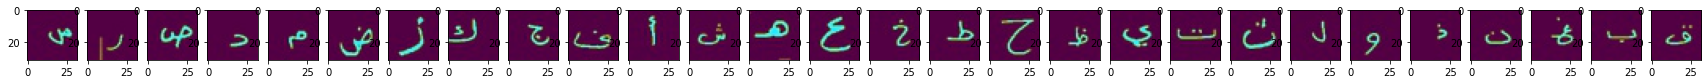

In [15]:
#overview of some data of training images from each class
fig, ax = plt.subplots(1, 28, figsize=(30, 12))
for i,name in enumerate(set(df_train['label'])):
    sample = df_train[df_train['label'] == name].sample(1)
    image_path=sample['path'].item()
    X = cv2.imread(image_path)
    ax[i].imshow(X)

In [16]:
def read_image(path):
    '''
    this function read the image by using opencv and return image
    '''
    img=cv2.imread(path)
    return img

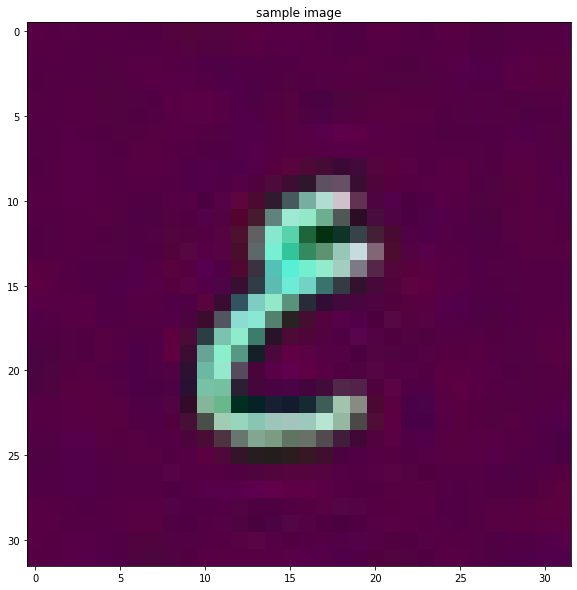

In [21]:
N = df_train.shape[0]
x_train = np.empty((N, 32, 32, 3), dtype=np.uint8)
for i, path in enumerate((df_train['path'])):
    x_train[i, :, :, :] = read_image(path)
fig=plt.figure(figsize=(20, 10))
plt.title('sample image')
plt.imshow(x_train[0])

In [19]:
N = df_test.shape[0]
x_test = np.empty((N, 32, 32, 3), dtype=np.uint8)
for i, path in enumerate((df_test['path'])):
    x_test[i, :, :, :] = read_image(path)

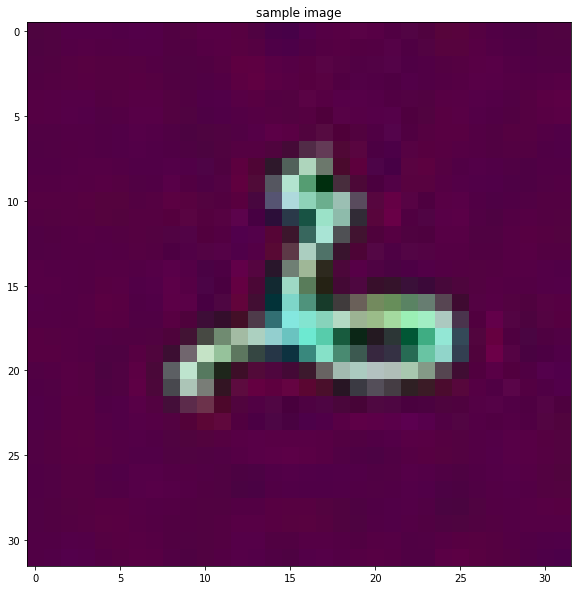

In [27]:
fig=plt.figure(figsize=(20, 10))
plt.title('sample image')
plt.imshow(x_test[19])

In [28]:
print(x_train[10].shape)
print(x_test[40].shape)

(32, 32, 3)
(32, 32, 3)


In [29]:
#converting labels from string to int
from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()
y_train=lb.fit_transform(df_train['label'])
from tensorflow.keras.utils import to_categorical  
y_train=to_categorical(y_train, num_classes=28)

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense, Flatten

def create_model(activation='relu', optimizer='adam', kernel_initializer='he_normal'):
    '''
    This function will create a sequential CNN model, which is being utilized inorder to lean patterns and classify classes
    '''
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), padding='same', input_shape=(32, 32, 3), activation= activation, kernel_initializer=kernel_initializer))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', activation= activation, kernel_initializer=kernel_initializer))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Flatten())

    model.add(Dense(32, activation= activation, kernel_initializer=kernel_initializer, kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(28, activation='softmax'))

    model.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',
                   metrics=['accuracy'])
    return model

In [31]:
model = create_model()                                                          
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                        

In [33]:
from keras.callbacks import Callback, EarlyStopping
early_stop = EarlyStopping(
                monitor='val_loss', 
                mode='auto',
                verbose=1, 
                patience=8 
              )

In [49]:
#model training
history=model.fit(x_train, y_train, 
                    validation_split=0.3,
                    callbacks=[early_stop],
                    epochs=1100, batch_size=64, verbose=1)

Epoch 1/1100
147/147 [==============================] - 13s 88ms/step - loss: 0.3017 - accuracy: 0.9634 - val_loss: 11.1220 - val_accuracy: 0.0357
Epoch 2/1100
147/147 [==============================] - 14s 92ms/step - loss: 0.3050 - accuracy: 0.9635 - val_loss: 11.9313 - val_accuracy: 0.0382
Epoch 3/1100
147/147 [==============================] - 14s 93ms/step - loss: 0.2971 - accuracy: 0.9652 - val_loss: 10.8947 - val_accuracy: 0.0434
Epoch 4/1100
147/147 [==============================] - 12s 85ms/step - loss: 0.2965 - accuracy: 0.9651 - val_loss: 10.3251 - val_accuracy: 0.0439
Epoch 5/1100
147/147 [==============================] - 12s 81ms/step - loss: 0.2899 - accuracy: 0.9658 - val_loss: 12.1845 - val_accuracy: 0.0412
Epoch 6/1100
147/147 [==============================] - 13s 85ms/step - loss: 0.2763 - accuracy: 0.9701 - val_loss: 11.3799 - val_accuracy: 0.0446
Epoch 7/1100
147/147 [==============================] - 12s 84ms/step - loss: 0.2701 - accuracy: 0.9727 - val_loss: 11

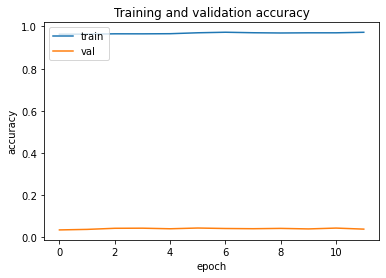

In [50]:
#plotting accuracy of model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

Text(0.5, 0, 'epoch')

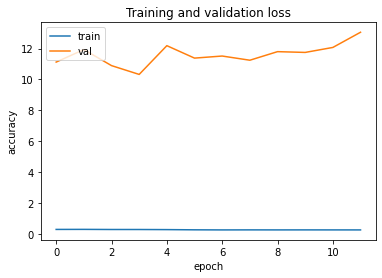

In [51]:
# plotting loss of model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [52]:
#saving model weights
model.save('HAJARhandWAr.h5')

In [53]:
# model predictions and decoding
pred=model.predict(x_test)
res=np.argmax(pred,axis=1)
res=lb.inverse_transform(res)
res[:5]

105/105 [==============================] - 1s 13ms/step


array(['train\\ain', 'train\\ain', 'train\\ain', 'train\\ain',
       'train\\ain'], dtype=object)

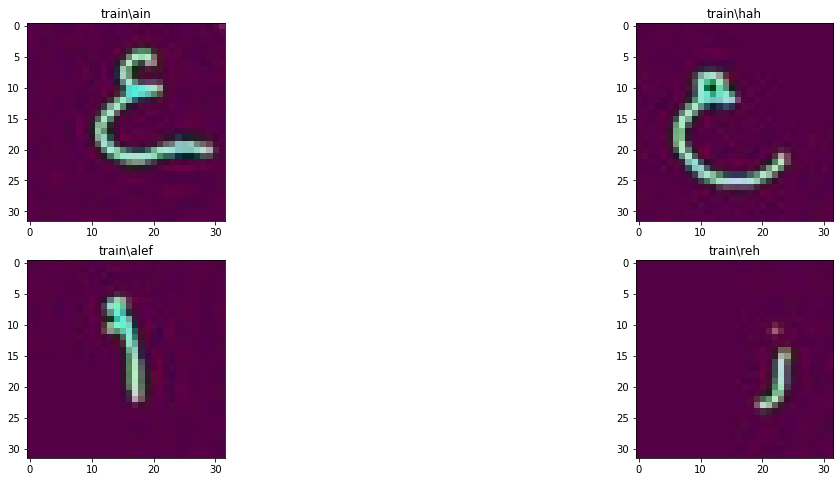

In [54]:
#prediction as title and test images
fig, axs = plt.subplots(2, 2,figsize=(20,8))
axs[0, 0].imshow(x_test[2])
axs[0, 0].set_title(res[2])
axs[0, 1].imshow(x_test[8])
axs[0, 1].set_title(res[8])
axs[1, 0].imshow(x_test[232])
axs[1, 0].set_title(res[232])
axs[1, 1].imshow(x_test[3305])
axs[1, 1].set_title(res[3305])
plt.show()

In [55]:
#storing predictions in test dataframe
df_test['label']=res
df_test.head()

,path,label
0,./arabic-chars-mnist/test\ain1042.jpg,train\ain
1,./arabic-chars-mnist/test\ain1043.jpg,train\ain
2,./arabic-chars-mnist/test\ain1098.jpg,train\ain
3,./arabic-chars-mnist/test\ain1099.jpg,train\ain
4,./arabic-chars-mnist/test\ain1154.jpg,train\ain
